In [13]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../..")

from tqdm import tqdm
import torch
import ot


from torch.nn import MSELoss
from torch.distributions import Uniform
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import zoom
from sklearn.datasets import make_moons
from flows.FlowMatching.model.FlowMatchingModel import FlowMatchingModel
from flows.FlowMatching.train_flow import train_flow_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), np.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()

(256, 256, 2)
1.0


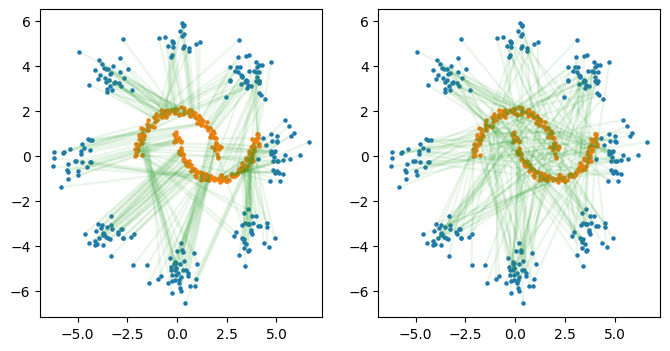

In [15]:
n_samples = 256
x = np.random.randn(n_samples, 2)
gauss_8 = sample_8gaussians(256)

x = gauss_8.numpy()

y, _ = make_moons(n_samples=n_samples, noise=0.05)
y = 2 * y
diff = y[None, :] ** 2 - x[:, None]
print(diff.shape)
M = np.sqrt(diff[..., 0] ** 2 + diff[..., 1] ** 2)
a = ot.unif(n_samples)
b = ot.unif(n_samples)

M = M  # / M.max()
gamma = ot.emd(a, b, M, numThreads=1)
print(gamma.sum())
source, destination = np.where(gamma > 0)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, (s, d) in enumerate(zip(source, destination)):
    ax[0].plot([x[s, 0], y[d, 0]], [x[s, 1], y[d, 1]], color="tab:green", alpha=0.1)
    ax[1].plot([x[i, 0], y[i, 0]], [x[i, 1], y[i, 1]], color="tab:green", alpha=0.1)

ax[0].scatter(x[:, 0], x[:, 1], s=5)
ax[0].scatter(y[:, 0], y[:, 1], color="tab:orange", s=5)
ax[1].scatter(x[:, 0], x[:, 1], s=5)
ax[1].scatter(y[:, 0], y[:, 1], color="tab:orange", s=5)

In [16]:
def get_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()]) / 1e6

Num params: 0.399106 [Million]


100%|██████████| 10000/10000 [00:32<00:00, 304.99it/s, Epoch:9999/10000	Loss =   0.986399]


Num params: 0.399106 [Million]


100%|██████████| 10000/10000 [00:48<00:00, 206.91it/s, Epoch:9999/10000	Loss =   0.094259]
/home/fmirkovic/blogs/flows/FlowMatching/notebooks/../../../flows/FlowMatching/model/FlowMatchingModel.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt = torch.tensor(dt).float().to(x0.device)


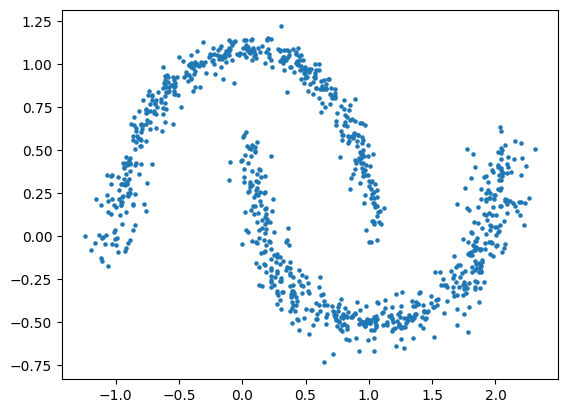

In [19]:
from flows.FlowMatching.optimal_transport import optimal_transport_sampling


def train_on_moons(
    num_epochs=10000, lr=1e-3, device="cuda:3", optimal_transport=True, **model_kwargs
):
    loss_fn = MSELoss()
    model = FlowMatchingModel(**model_kwargs)
    print(f"Num params: {get_num_params(model)} [Million]")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    t_dist = Uniform(low=torch.zeros(1).float(), high=torch.ones(1).float())
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        x1, _ = make_moons(n_samples=128, noise=0.05)
        optimizer.zero_grad()
        x1 = torch.tensor(x1).float().to(device)
        x0 = model.base_dist.rsample(sample_shape=(x1.shape[0],))
        if optimal_transport:
            src, dst = optimal_transport_sampling(x0, x1)
            x0 = x0[src, ...]
            x1 = x1[dst, ...]
        target_velocity = x1 - x0
        t = t_dist.rsample(sample_shape=(x1.shape[0],)).to(device).view(-1, 1)
        xt = t * x1 + (1 - t) * x0
        pred_velocity = model(xt, t)
        loss: torch.Tensor = loss_fn(pred_velocity, target_velocity)
        loss.backward()
        optimizer.step()
        pbar.set_postfix_str(
            f"Epoch:{epoch:4d}/{num_epochs}\tLoss = {loss.item():10.6f}"
        )
    return model


model_kwargs = dict(data_dims=2, hidden_dim=256, num_layers=6, dt=1e-2)
model = train_on_moons(optimal_transport=False, **model_kwargs)
model_ot = train_on_moons(optimal_transport=True, **model_kwargs)

xsampled = model.sample(1000).detach().cpu().numpy()
plt.scatter(xsampled[:, 0], xsampled[:, 1], s=5)

In [34]:
def create_generation_trajectory_animation(
    X,
    save_path=None,
    fps=10,
    title: str = "Data Trajectory",
    trace_paths=False,
    trace_alpha=0.3,
):
    """
    Enhanced version with smoother interpolation, better controls, and optional path tracing.

    Args:
        X: Array of data samples for each time step (shape: [n_timesteps, n_points, 2])
        save_path: Optional path to save the animation
        fps: Frames per second
        zoom_factor: Upsampling factor for smoother visualization
        title: Title for the animation
        trace_paths: If True, shows the path each point has traveled
        trace_alpha: Transparency of the traced paths (0-1)
    """

    fig, ax = plt.subplots(figsize=(12, 10))

    # Initialize scatter plot
    scatter = ax.scatter(X[0][:, 0], X[0][:, 1], c="tab:blue", s=50, alpha=0.7)

    # Initialize path lines if tracing is enabled
    path_lines = []
    if trace_paths:
        n_points = X[0].shape[0]
        for i in range(n_points):
            (line,) = ax.plot([], [], "-", alpha=trace_alpha, linewidth=1, color="gray")
            path_lines.append(line)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.3)

    # Add time step text
    time_text = ax.text(
        0.02,
        0.98,
        "",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

    def animate(tidx):
        # Update scatter plot positions
        current_positions = X[tidx]
        scatter.set_offsets(current_positions)

        # Update path traces if enabled
        if trace_paths:
            for i, line in enumerate(path_lines):
                # Get trajectory for point i up to current time
                trajectory = X[: tidx + 1, i, :]
                line.set_data(trajectory[:, 0], trajectory[:, 1])

        # Update time step text
        time_text.set_text(f"Time Step: {tidx}")

        # Return all artists that need to be redrawn
        artists = [scatter, time_text]
        if trace_paths:
            artists.extend(path_lines)

        return artists

    # Create animation
    anim = animation.FuncAnimation(
        fig, animate, frames=len(X), interval=1000 / fps, blit=True, repeat=True
    )

    # Save animation if path provided
    if save_path:
        print(f"Saving animation to {save_path}...")
        if save_path.endswith(".gif"):
            anim.save(save_path, writer="pillow", fps=fps)
        elif save_path.endswith(".mp4"):
            anim.save(save_path, writer="ffmpeg", fps=fps, bitrate=1800)
        print("Animation saved!")

    plt.tight_layout()
    return anim

In [35]:
X = [
    step.detach().cpu().numpy()[None]
    for step in model.sample(1000, return_intermediates=True)
]
X_ot = [
    step.detach().cpu().numpy()[None]
    for step in model_ot.sample(1000, return_intermediates=True)
]
X = np.concatenate(X, axis=0)
X_ot = np.concatenate(X_ot, axis=0)
X.shape

(101, 1000, 2)

Saving animation to trajectory.gif...
Animation saved!


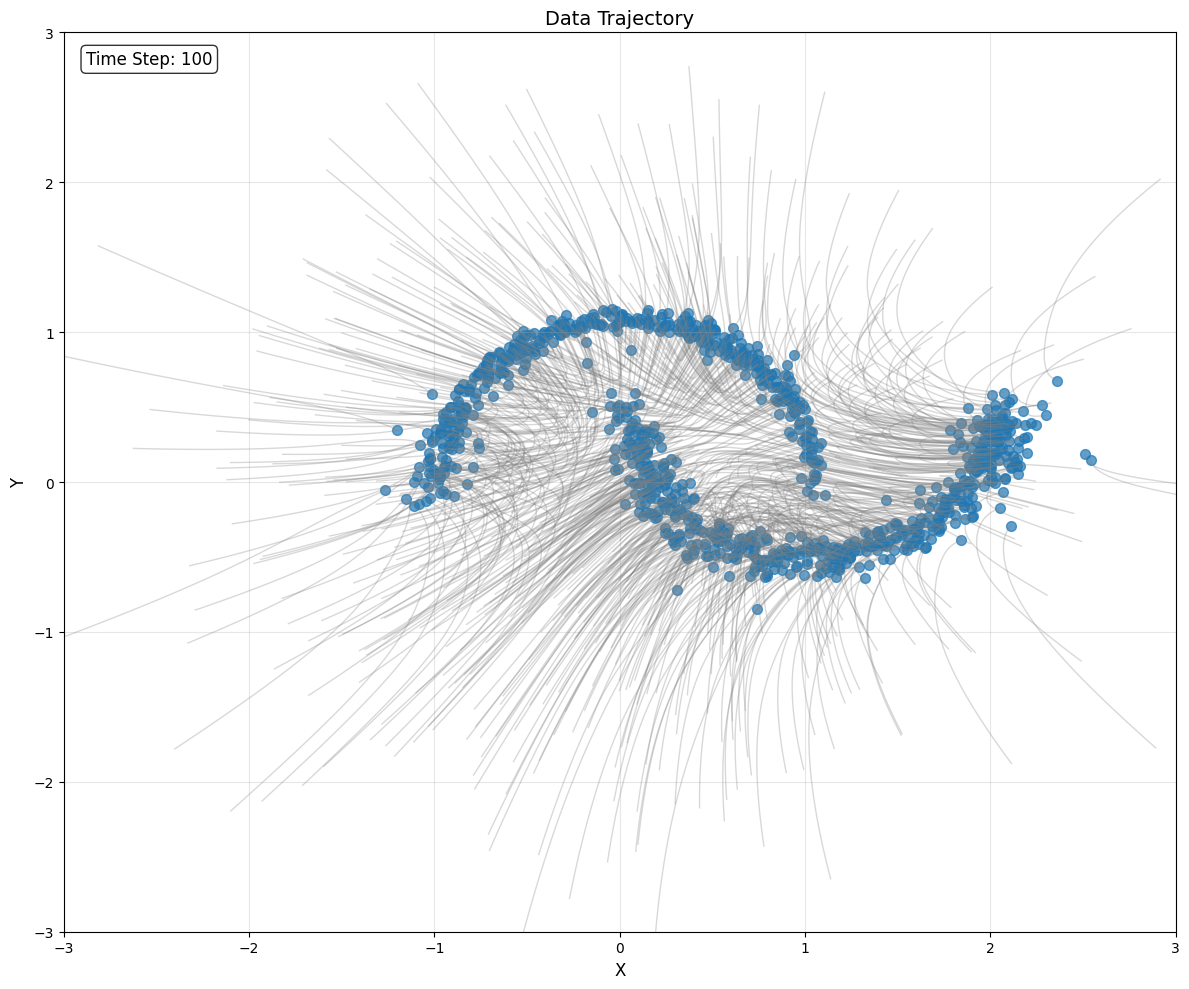

In [36]:
create_generation_trajectory_animation(X, save_path="trajectory.gif", trace_paths=True)

In [ ]:
create_generation_trajectory_animation(
    X_ot, save_path="trajectory_ot.gif", trace_paths=True
)

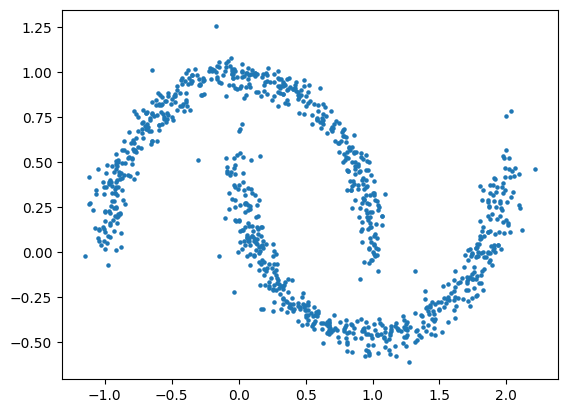

In [20]:
xsampled = model_ot.sample(1000).detach().cpu().numpy()
plt.scatter(xsampled[:, 0], xsampled[:, 1], s=5)

In [ ]:
@torch.no_grad()
def animate_vector_field(
    flow_model: FlowMatchingModel,
    x_range=(-3, 3),
    y_range=(-3, 3),
    grid_density=20,
    arrow_scale=1.0,
    frames=110,
    interval=110,
    figsize=(10, 8),
    dt: float = 1e-2,
    arrow_length: float = 0.1,
    title: str = "Flow Velocity Field",
):
    """
    Animate a 2D vector field.

    Parameters:
    -----------
    flow_model : FlowMatchingModel
    x_range : tuple
        Range for x-axis (min, max)
    y_range : tuple
        Range for y-axis (min, max)
    grid_density : int
        Number of grid points along each axis
    arrow_scale : float
        Scale factor for arrow size
    frames : int
        Number of animation frames
    interval : int
        Delay between frames in milliseconds
    figsize : tuple
        Figure size (width, height)

    Returns:
    --------
    matplotlib.animation.FuncAnimation
    """

    flow_model.eval()
    # Create coordinate grids
    x = np.linspace(x_range[0], x_range[1], grid_density)
    y = np.linspace(y_range[0], y_range[1], grid_density)
    X, Y = np.meshgrid(x, y)
    grid = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
    grid = torch.tensor(grid).float()
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

    # Initialize quiver plot
    field = flow_model(grid, torch.tensor(1.0).view(1, 1))
    field = field.view(grid_density, grid_density, 2).numpy()
    U, V = field[..., 0], field[..., 1]

    magnitude = np.sqrt(U**2 + V**2)
    nonzero_mask = magnitude > 1e-10
    U_norm = np.zeros_like(U)
    V_norm = np.zeros_like(V)
    U_norm[nonzero_mask] = U[nonzero_mask] / magnitude[nonzero_mask] * arrow_length
    V_norm[nonzero_mask] = V[nonzero_mask] / magnitude[nonzero_mask] * arrow_length

    quiver = ax.quiver(
        X,
        Y,
        U_norm,
        V_norm,
        magnitude,
        angles="xy",
        scale_units="xy",
        scale=1 / arrow_scale,
        alpha=0.8,
        color="blue",
    )
    cbar = plt.colorbar(quiver, ax=ax, label="Magnitude")

    @torch.no_grad()
    def update(frame):
        """Update function for animation"""
        t = torch.tensor(frame * dt).float().view(1, 1)
        field: torch.Tensor = flow_model(grid, t)
        field = field.view(grid_density, grid_density, 2).numpy()
        U, V = field[..., 0], field[..., 1]  # Time step
        magnitude = np.sqrt(U**2 + V**2)
        nonzero_mask = magnitude > 1e-10
        U_norm = np.zeros_like(U)
        V_norm = np.zeros_like(V)
        U_norm[nonzero_mask] = U[nonzero_mask] / magnitude[nonzero_mask] * arrow_length
        V_norm[nonzero_mask] = V[nonzero_mask] / magnitude[nonzero_mask] * arrow_length

        quiver.set_UVC(U_norm, V_norm, magnitude)
        ax.set_title(f"2D Vector Field Animation (t = {t.item():.2f})")
        return (quiver,)

    # Create animation
    anim = animation.FuncAnimation(
        fig, update, frames=frames, interval=interval, blit=False, repeat=True
    )

    plt.tight_layout()
    return anim

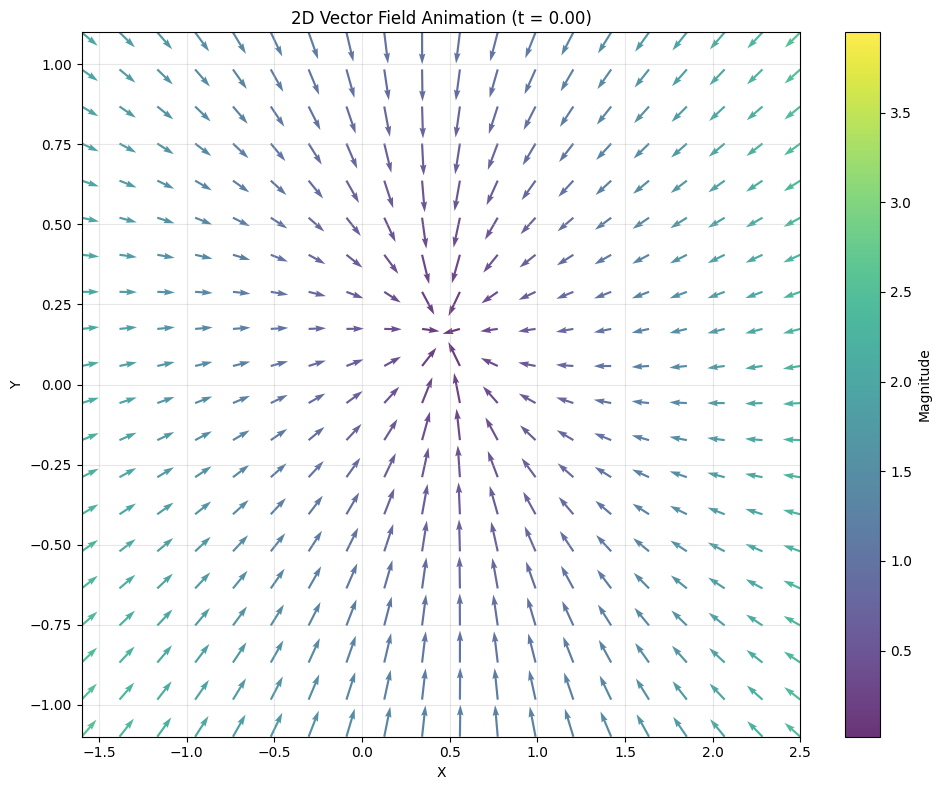

In [ ]:
anim = animate_vector_field(
    flow_model=model.to("cpu"), x_range=(-1.6, 2.5), y_range=(-1.1, 1.1)
)
anim.save("flow_field.gif", writer="pillow", fps=20)

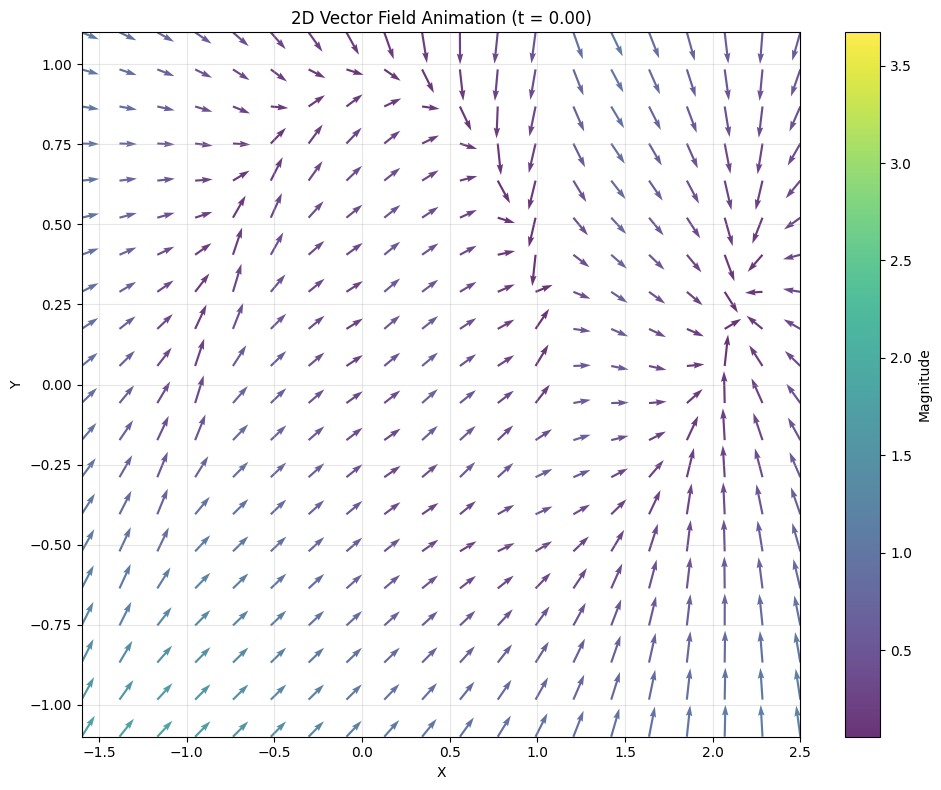

In [ ]:
anim = animate_vector_field(
    flow_model=model_ot.to("cpu"), x_range=(-1.6, 2.5), y_range=(-1.1, 1.1)
)
anim.save("flow_field_ot.gif", writer="pillow", fps=20)

In [ ]:
def create_smooth_histogram_animation(
    X, save_path=None, fps=10, zoom_factor=2, title: str = "Density Evolution"
):
    """
    Enhanced version with smoother interpolation and better controls.

    Args:
        X: Array of data samples for each time step
        save_path: Optional path to save the animation
        fps: Frames per second
        zoom_factor: Upsampling factor for smoother visualization
    """

    fig, ax = plt.subplots(figsize=(12, 10))

    # Pre-compute all histograms for consistent color scaling
    print("Pre-computing histograms...")
    all_histograms = []
    max_density = 0

    for tidx in range(len(X)):
        H, xbins, ybins = np.histogram2d(
            x=X[tidx][:, 0],
            y=X[tidx][:, 1],
            range=([-3, 3], [-3, 3]),
            bins=150,
            density=True,
        )

        # Upsample
        H_img = zoom(H, zoom=(zoom_factor, zoom_factor), order=1)
        x_edges = zoom(xbins, zoom=zoom_factor, order=1)
        y_edges = zoom(ybins, zoom=zoom_factor, order=1)

        all_histograms.append((H_img, x_edges, y_edges))
        max_density = max(max_density, H_img.max())

    print(f"Max density: {max_density:.4f}")

    # Initialize plot
    im = ax.pcolormesh(
        all_histograms[0][1][1:-1],
        all_histograms[0][2][1:-1],
        all_histograms[0][0].T,
        shading="auto",
        cmap="viridis",
        vmin=0,
        vmax=max_density,
    )

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_xlabel("X", fontsize=12)
    ax.set_ylabel("Y", fontsize=12)
    ax.set_title(title, fontsize=14)

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Density", fontsize=12)

    # Add time step text
    time_text = ax.text(
        0.02,
        0.98,
        "",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

    def animate(tidx):
        H_img, x_edges, y_edges = all_histograms[tidx]

        # Update the plot data
        im.set_array(H_img.T.ravel())

        # Update time step text
        time_text.set_text(f"Time Step: {tidx}")

        return [im, time_text]

    # Create animation
    anim = animation.FuncAnimation(
        fig, animate, frames=len(X), interval=1000 / fps, blit=True, repeat=True
    )

    # Save animation if path provided
    if save_path:
        print(f"Saving animation to {save_path}...")
        if save_path.endswith(".gif"):
            anim.save(save_path, writer="pillow", fps=fps)
        elif save_path.endswith(".mp4"):
            anim.save(save_path, writer="ffmpeg", fps=fps, bitrate=1800)
        print("Animation saved!")

    plt.tight_layout()
    return anim

/home/fmirkovic/blogs/flows/FlowMatching/notebooks/../../../flows/FlowMatching/model/FlowMatchingModel.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt = torch.tensor(dt).float().to(x0.device)


Pre-computing histograms...
Max density: 1.8365
Saving animation to density_evolution_ot.gif...
Animation saved!


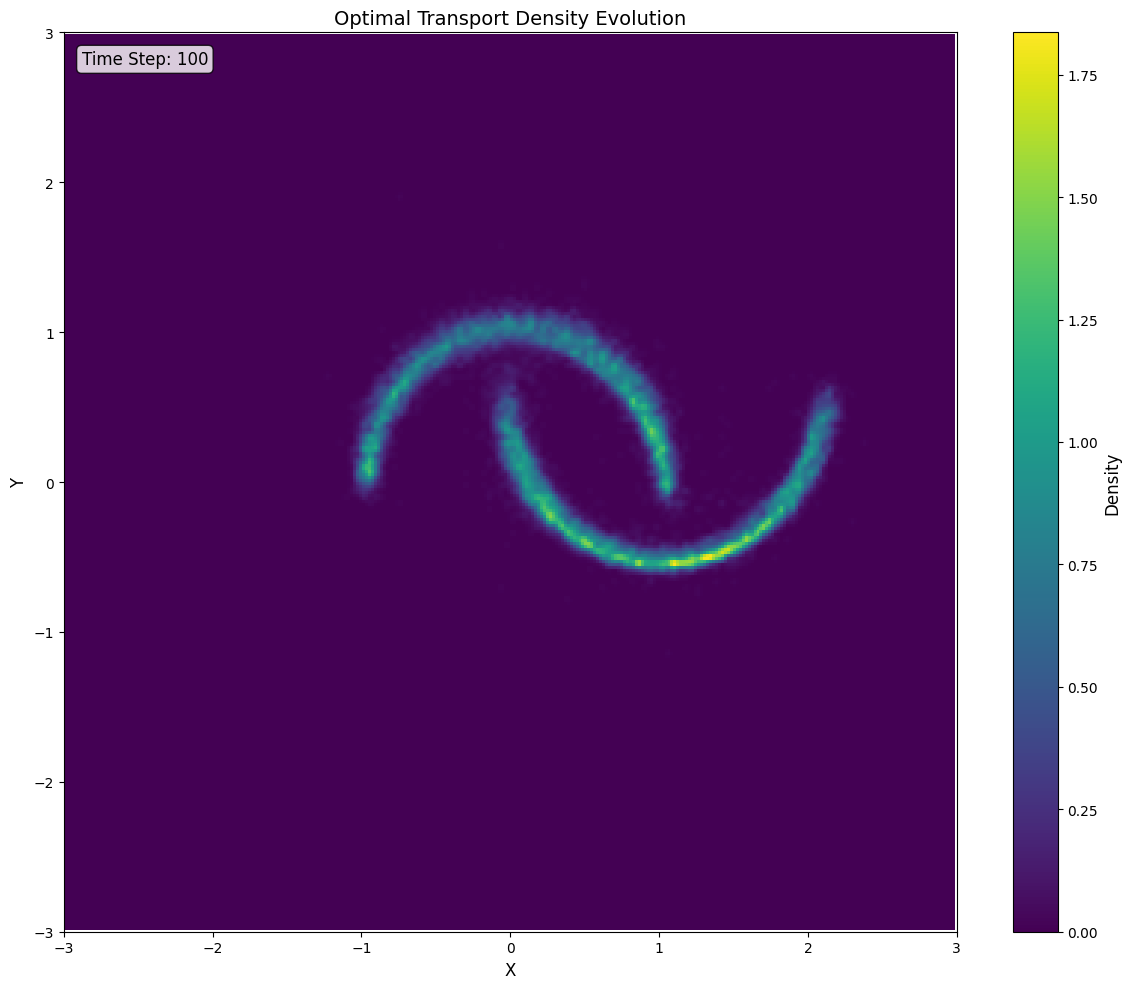

In [ ]:
xsampled = [
    step.cpu().numpy() for step in model_ot.sample(20000, return_intermediates=True)
]
anim = create_smooth_histogram_animation(
    X=xsampled,
    save_path="density_evolution_ot.gif",
    title="Optimal Transport Density Evolution",
)

/home/fmirkovic/blogs/flows/FlowMatching/notebooks/../../../flows/FlowMatching/model/FlowMatchingModel.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dt = torch.tensor(dt).float().to(x0.device)


Pre-computing histograms...
Max density: 1.8627
Saving animation to density_evolution.gif...
Animation saved!


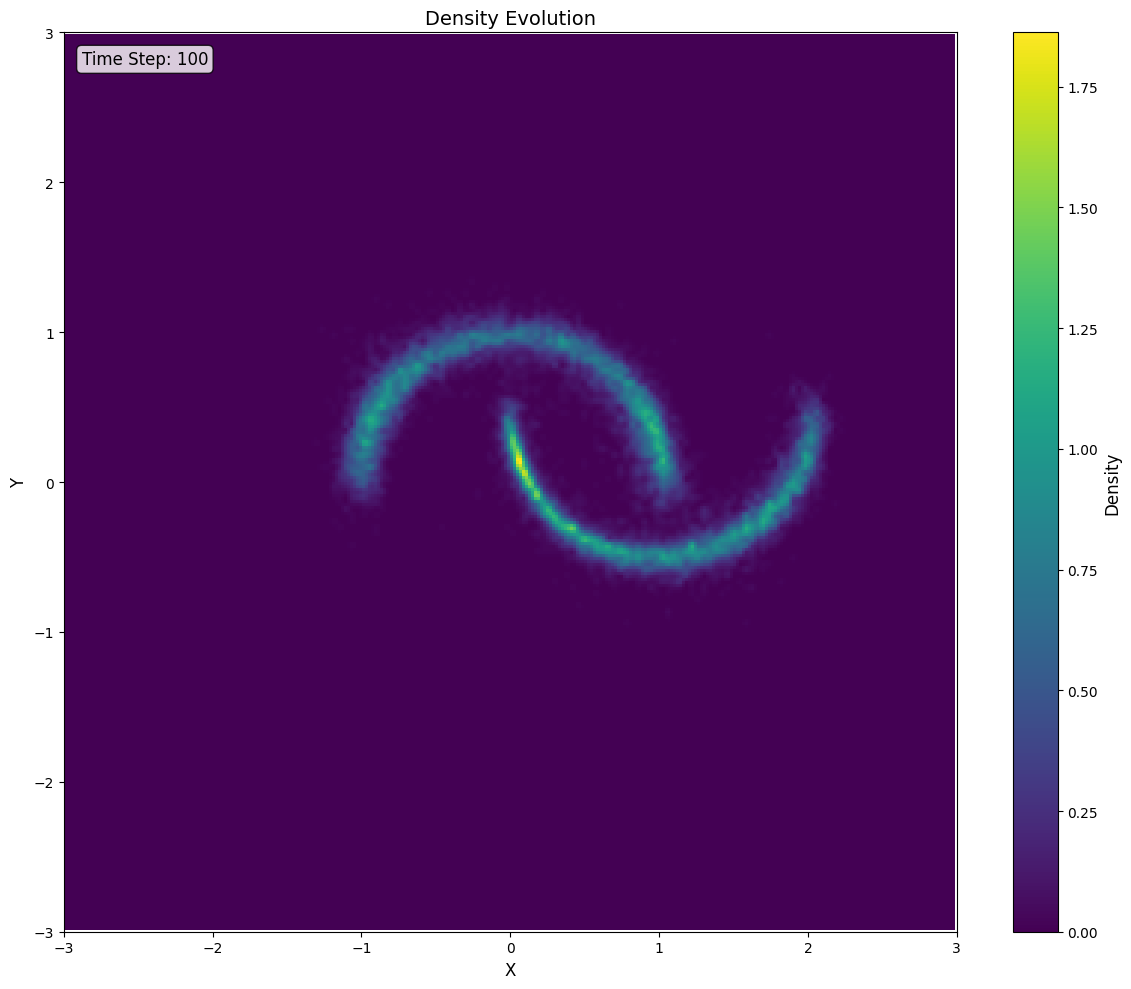

In [ ]:
xsampled = [
    step.cpu().numpy() for step in model.sample(20000, return_intermediates=True)
]
anim = create_smooth_histogram_animation(X=xsampled, save_path="density_evolution.gif")

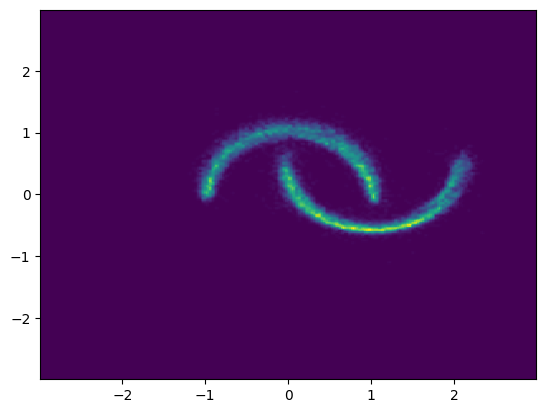

In [ ]:
tidx = 95
H, xbins, ybins = np.histogram2d(
    x=xsampled[tidx][:, 0],
    y=xsampled[tidx][:, 1],
    range=([-3, 3], [-3, 3]),
    bins=150,
    density=True,
)
fig, ax = plt.subplots()


H_img = zoom(H, zoom=(2, 2), order=1)
x_edges = zoom(xbins, zoom=2, order=1)
y_edges = zoom(ybins, zoom=2, order=1)


ax.pcolormesh(x_edges[1:-1], y_edges[1:-1], H_img.T)

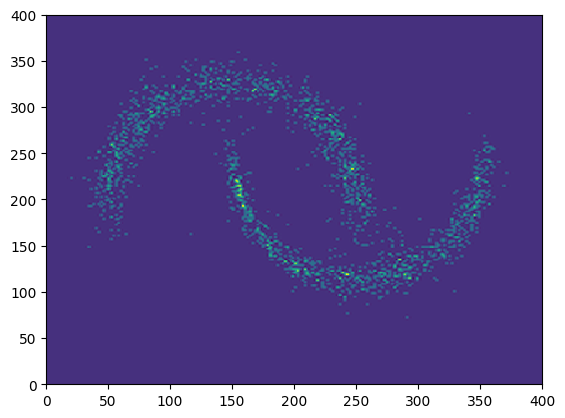

In [ ]:
plt.pcolormesh(H.T)